# Определение стоимости автомобиля на вторичном рынке

Сервис по продаже подержанных автомобилей разрабатывает приложение, в котором клиент может быстро узнать рыночную стоимость автомобиля, введя информацию о пробеге, комплектации, тх и проч. В нашем распоряжении размеченные исторические данные. Вам нужно построить модель для определения стоимости. 

Задача: __построить модель для определения стоимости автомобиля по его характеристикам__. Заказчику важны __качество предсказания__ (Ключевая метрика - RMSE), __скорость предсказания__, __время обучения__.

# 1. Подготовка данных

## Предварительное изучение данных

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import copy
import random
import math

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
state = 1234

In [3]:
df = pd.read_csv('...')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [5]:
df.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [6]:
len(df[(df['VehicleType'].isnull()==True)
   |(df['Gearbox'].isnull()==True)
   |(df['Model'].isnull()==True)
   |(df['FuelType'].isnull()==True)
   |(df['NotRepaired'].isnull()==True)])

108555

Присутствуют пропуски в столбцах VehicleType, Gearbox, Model, FuelType, NotRepaired, причем удалить их все нельзя, вместе они составляют слишком большую часть выборки. Также как минимум в столбце Price присутствуют нулевые значения. Проверим все столбцы на наличие нулей.

In [7]:
print('Количество нулей')
int_columns = list(df.dtypes[df.dtypes=='int64'].index)
for i in int_columns:
    print(i + ':', len(df[df[i]<0.0001]))

Количество нулей
Price: 10772
RegistrationYear: 0
Power: 40225
Kilometer: 0
RegistrationMonth: 37352
NumberOfPictures: 354369
PostalCode: 0


В столбце NumperOfPictures нули объяснимы, это объекты с нулевым количеством иллюстраций, что вполне может быть.  Но в столбцах Price, Power и RegistrationMonth нулей быть не может, уж точно в таких больших количествах. 

In [8]:
print('Диапазон значений количественных признаков')
quantitative_columns = list(df.dtypes[df.dtypes=='int64'].index)
for i in quantitative_columns:
    print(i + ':', list(pd.Series(df[i].unique()).sort_values(ascending = False).head()),'...',
         list(pd.Series(df[i].unique()).sort_values(ascending = False).tail()))

Диапазон значений количественных признаков
Price: [20000, 19999, 19998, 19997, 19995] ... [4, 3, 2, 1, 0]
RegistrationYear: [9999, 9996, 9450, 9229, 9000] ... [1200, 1111, 1039, 1001, 1000]
Power: [20000, 19312, 19211, 19208, 17932] ... [4, 3, 2, 1, 0]
Kilometer: [150000, 125000, 100000, 90000, 80000] ... [40000, 30000, 20000, 10000, 5000]
RegistrationMonth: [12, 11, 10, 9, 8] ... [4, 3, 2, 1, 0]
NumberOfPictures: [0] ... [0]
PostalCode: [99998, 99996, 99994, 99991, 99988] ... [1099, 1097, 1069, 1068, 1067]


Разброс значений количественных признаков очень большой, судя по наибольшим и наименьшим значениям встречаются аномальные значения. Так, встречаются анкеты с годом регистрации автомобиля в отдаленном будущем или в средневековье, с неправдоподобно большой или маленькой мощностью, нулевым месяцем регистрации.  
Так же стоит обратить внимание на то, что в NumberOfPictures, судя по всему, есть только одно значение - 0. В дальнейшем, возможно, стоит вообще отказаться от этого признака, поскольку он никаким образом не влияет на обучение моделей.

In [9]:
df['NumberOfPictures'].unique()

array([0], dtype=int64)

In [10]:
df['NotRepaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

In [11]:
df['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

Признак NotRepaired принимает только два значения yes или no, когда он не отсутствует, значит, его для удобства можно перевести в булеву переменную. То же самое можно сделать с Gearbox.
Также формат данных можно поменять у DateCrawled, DateCreated и LastSeen, однако возможно они не пригодятся при обучении моделей, как и PostalCode.

### Вывод

В столбцах VehicleType, Gearbox, Model, FuelType, NotRepaired присутствует большое количество пропусков, удалить их все нельзя, как минимум часть из них придется заполнить.  
В столбцах RegistrationYear, Power, RegistrationMonth есть неправдоподобные нули и аномальные значения.  
В столбцах Gearbox и IsRepaired формат данных можно поменять на формат логических переменных, а в DateCrawled, DateCreated и LastSeen - на datetime.

## Обработка пропусков

Прежде, чем заполнять пропущенные значения, посмотрим на распределение значений в признаках более подробно.

In [12]:
pivot_counts = df.pivot_table(index = 'Model', values = 'Price', aggfunc = 'count')

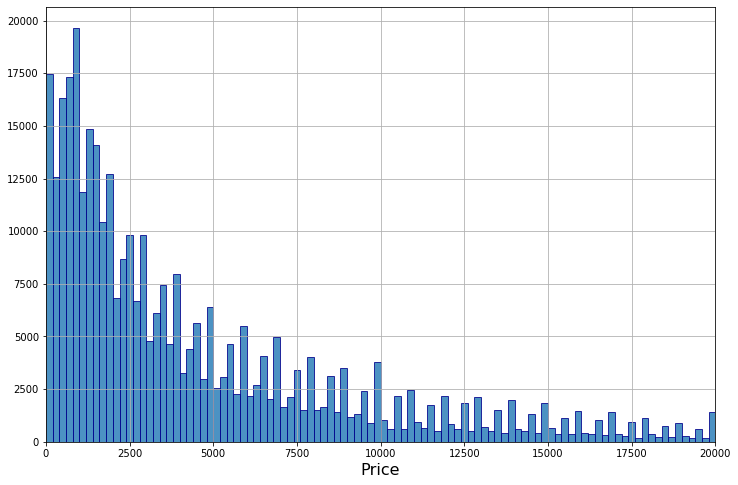

In [13]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
ax.set_xlim([df['Price'].min()-1,df['Price'].max()+2])
ax.grid(b=True, which = 'major' )
plt.hist(df['Price'], alpha=0.8, bins = 100, edgecolor = 'darkblue')
plt.xlabel('Price', fontsize = 16)
plt.show()

На гистограмме видно, что в столбце Price относительно много близких к нулю значений. Рассмотрим подробнее левый край гистограммы.

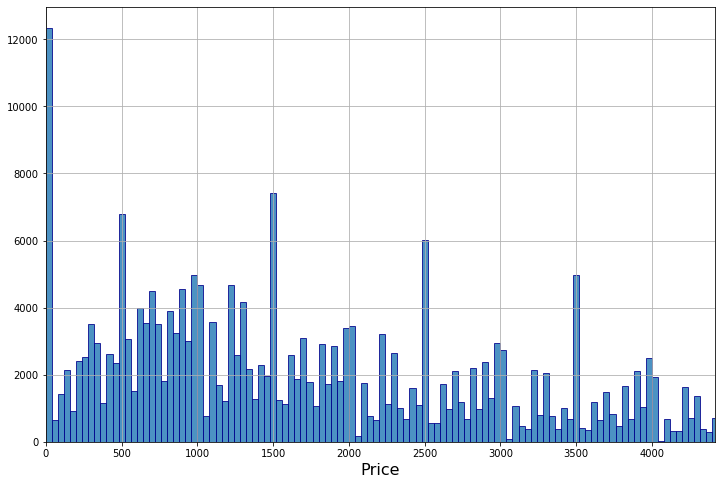

In [14]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
ax.set_xlim([df['Price'].min()-1,df['Price'].mean()+2])
ax.grid(b=True, which = 'major' )
plt.hist(df['Price'], alpha=0.8, bins = 500, edgecolor = 'darkblue')
plt.xlabel('Price', fontsize = 16)
plt.show()

Теоретически, нулевое значение цены, указанное в анкете, возможно, но это довольно маловероятно само по себе, и тем более подозрительно, что нулевые цены присутствуют в таком большом количестве. Скорее всего это ошибка. Ошибками такде с большой вероятностью являются близкие к нулю значения - даже поддержанный автомобиль вряд ли будет продаваться за копейки.  
Поскольку мы не можем менять данные в целевом признаке, подозрительные значения лучше удалить. Подозрительными будем считать цены ниже определенного порога, например, 300 евро.  
Средняя цена подержанного автомобиля в России около 500 тыс. рублей (https://www.rbc.ru/rbcfreenews/5d383cbc9a79477cb6a167e6), в Германии до 10000 евро (https://www.statista.com/statistics/589613/average-prices-for-used-cars-germany/), но есть целые ресурсы и сообщества, на которых продаются автомобили около 500 евро - http://www.ooyyo.com/germany/used-cars-for-sale/c=CDA31D7114D3854F111BFE6FBB571553C6561C7116D38D88121FF46FAA651453/ - и даже ниже - https://www.facebook.com/groups/507973169302440/ - хотя настолько дешевых автомобилей действительно мало, и зачастую продаются они на специализированных площадках, спрос на них есть, значит, и на крупных площадках они продаваться могут.  
Что немало важно, строк с ценой ниже 250 евро - чуть более 5%, а строк с ценой ниже 500 евро уже 10%, и это без учета строк, которые могут уйти в результате обработки пропусков и дубликатов. Ставя порог выше этого диапазона, мы рискуем потерять значительную часть выборки.

In [15]:
len(df.query('Price < 300')) / len(df)

0.06536406965620582

In [16]:
df = df.query('Price >= 300')
len(df)

331206

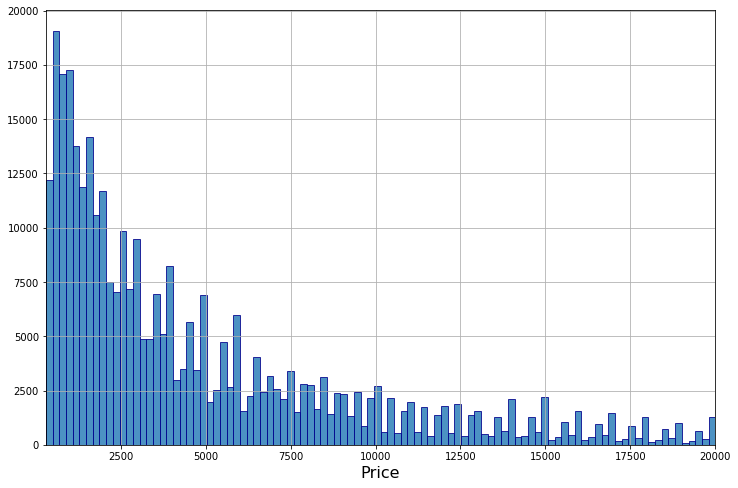

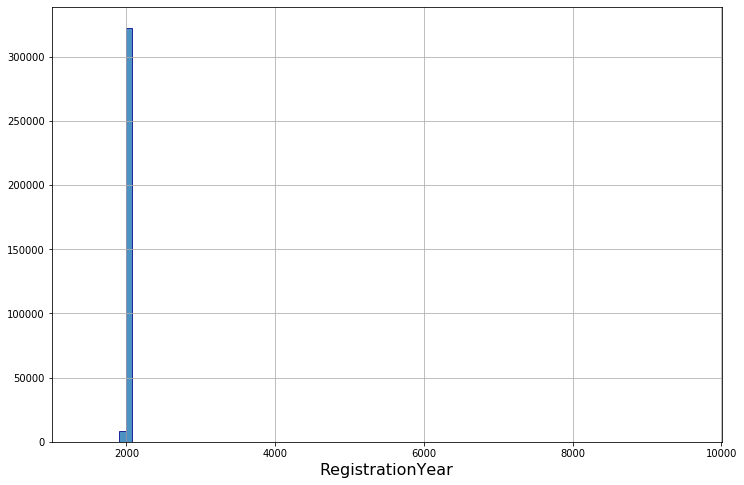

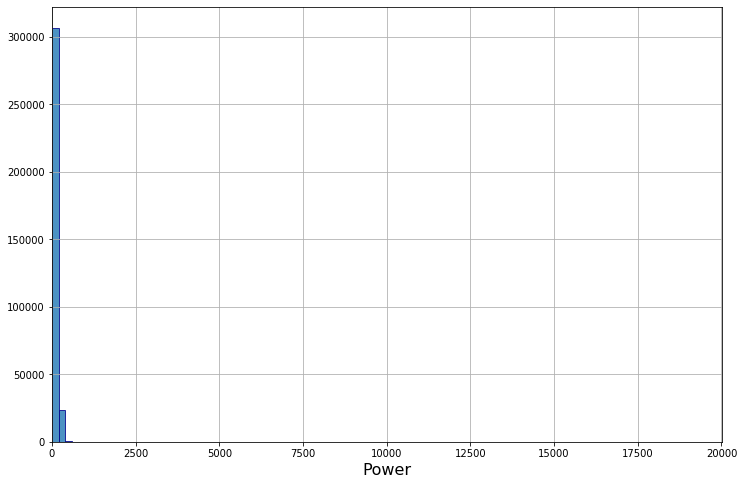

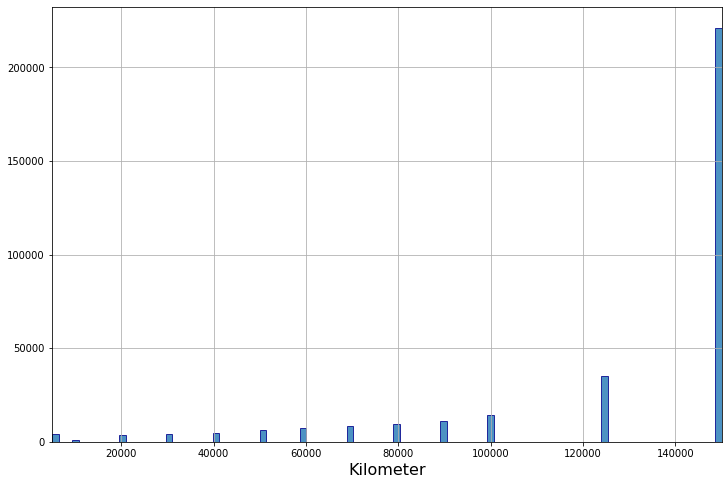

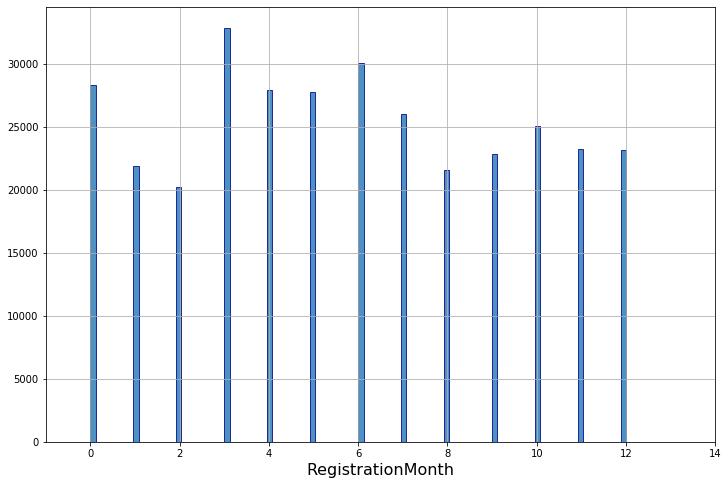

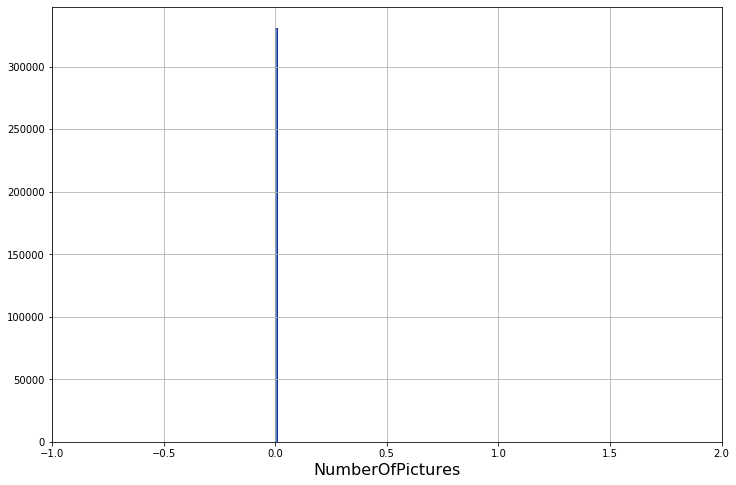

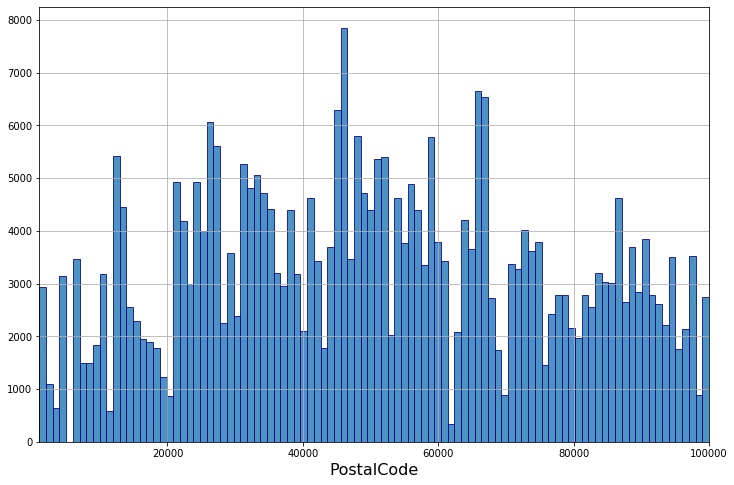

In [17]:

for i in quantitative_columns:
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot()
    ax.set_xlim([df[i].min()-1,df[i].max()+2])
    ax.grid(b=True, which = 'major' )
    plt.hist(df[i], alpha=0.8, bins = 100, edgecolor = 'darkblue')
    plt.xlabel(i, fontsize = 16)
    plt.show()

Аномальные значения в столбце Price устранены, но они остались в других столбцах. Например, на гистограммах, масштаб которых зависит от минимальных и максимальных значений признаков, видно, что в столбце RegistrationYear есть значения, отстоящие от XIX-XX веков на сотни лет.  


In [18]:
len(df.query('RegistrationYear > 2020 or RegistrationYear < 1920'))

119

Этих значений немного, поэтому мы можем их удалить. 

In [19]:
df = df.query('RegistrationYear <= 2020 and RegistrationYear >= 1920')
len(df)

331087

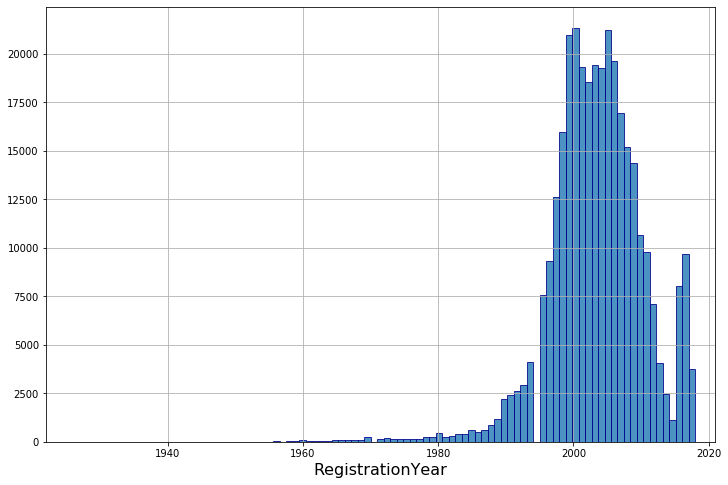

In [20]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
ax.set_xlim([df['RegistrationYear'].min()-1,df['RegistrationYear'].max()+2])
ax.grid(b=True, which = 'major' )
plt.hist(df['RegistrationYear'], alpha=0.8, bins = 100, edgecolor = 'darkblue')
plt.xlabel('RegistrationYear', fontsize = 16)
plt.show()

Ситуация с годами регистрации улучшилась, хотя мы задали излишне мягкие временные рамки для автомобилей. Мы видим, что количество зарегистрированных до 1980-1990 годов авто резко падает. Их вполне можно принять за аномалию, и житейское рассуждение подтверждает это: средний срок службы автомобиля составляет примерно 5-10 лет, но даже с постоянным ремонтом и тщательным уходом автомобиль вряд ли прослужит дольше 30-40 лет, поэтому зарегистрированные ранее 1970 года авто с большой вероятностью - ошибка.

In [21]:
len(df.query('RegistrationYear < 1970'))

1019

Благо, их не так много, и их можно спокойно удалить.

In [22]:
df = df.query('RegistrationYear >= 1970')

Аномалий в столбце Power, к сожалению, гораздо больше. Сверхвысоких мощностей среди данных немного, но близкие к нулю и нулевые показатели мощности составляют более 10% от выборки, что чрезмерно много для удаления. 

In [23]:
len(df.query('Power > 1200'))

224

In [24]:
len(df.query('Power < 50'))

36176

Мы удалим только сверхвысокие значения, потому что их немного, а нулевые и околонулевые значения мощности превратим в пропуски, чтобы потом заполнить.

In [25]:
df = df.query('Power <= 1200')

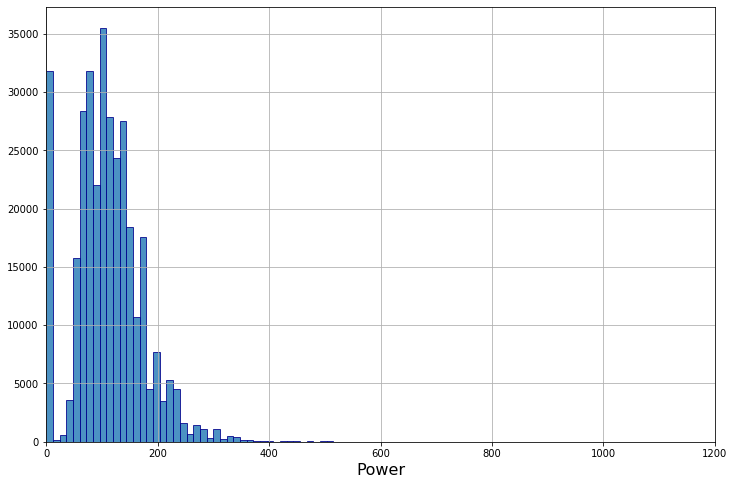

In [26]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
ax.set_xlim([df['Power'].min()-1,df['Power'].max()+2])
ax.grid(b=True, which = 'major' )
plt.hist(df['Power'], alpha=0.8, bins = 100, edgecolor = 'darkblue')
plt.xlabel('Power', fontsize = 16)
plt.show()

Теоретически, на сайте автомобилей с пробегом могут продаваться спорткары, однако вероятнее, что это ошибка, поэтому анкеты с автомобилями мощностью более 400 л.с. можно удалить - график демонстрирует, что мы почти ничего не потеряем.

In [27]:
len(df.query('Power > 400'))

429

In [28]:
df = df.query('Power <= 400')

In [29]:
df.loc[df['Power'] < 50, 'Power'] = np.nan
df.query('Power < 50')
df.loc[df['Power'].isnull()==True]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,NaN,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
37,2016-03-28 17:50:15,1500,NaN,2016,NaN,NaN,kangoo,150000,1,gasoline,renault,no,2016-03-28 00:00:00,0,46483,2016-03-30 09:18:02
54,2016-03-17 07:56:40,4700,wagon,2005,manual,NaN,signum,150000,0,NaN,opel,no,2016-03-17 00:00:00,0,88433,2016-04-04 04:17:32
55,2016-03-26 10:39:35,550,wagon,1999,manual,NaN,astra,150000,8,gasoline,opel,yes,2016-03-26 00:00:00,0,56759,2016-04-01 23:17:27
69,2016-04-01 11:56:40,1200,coupe,2001,NaN,NaN,astra,150000,0,NaN,opel,NaN,2016-04-01 00:00:00,0,47249,2016-04-07 08:46:07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354336,2016-03-05 18:57:45,3299,NaN,2005,auto,NaN,outlander,150000,4,petrol,mitsubishi,NaN,2016-03-05 00:00:00,0,17034,2016-03-06 04:17:37
354346,2016-03-07 17:06:35,2600,NaN,2005,auto,NaN,c_klasse,150000,9,NaN,mercedes_benz,NaN,2016-03-07 00:00:00,0,61169,2016-03-08 21:28:38
354360,2016-04-02 20:37:03,3999,wagon,2005,manual,NaN,3er,150000,5,gasoline,bmw,no,2016-04-02 00:00:00,0,81825,2016-04-06 20:47:12
354363,2016-03-27 20:36:20,1150,bus,2000,manual,NaN,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,0,26624,2016-03-29 10:17:23


С оставшейся аномалией - нулевым месяцем в RegistrationMonth - похожая проблема: слишком много объектов с данным значеним. При этом выдвинуть хоть какое-то доподлинное предположение о том, какой месяц мог подразумеваться под нулевым, мы не можем.

In [30]:
len(df.query('RegistrationMonth < 1'))

28032

Заменим все нулевые значения на пропуски, чтобы заполнить их.

In [31]:
df.loc[df['RegistrationMonth'] < 1, 'RegistrationMonth'] = np.nan

In [32]:
len(df[df['RegistrationMonth'].isnull()==True])

28032

In [33]:
df.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          29699
RegistrationYear         0
Gearbox              14471
Power                36176
Model                15537
Kilometer                0
RegistrationMonth    28032
FuelType             25549
Brand                    0
NotRepaired          59442
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Аномалии, которые можно было удалить, удалены, остальные превращены в отсутствующие значения, которые мы заполним вместе с остальными пропусками.  

Мы будем заполнять пропуски исходя из предпосылки, что пропуски можно заполнить наиболее встречающимися или медианными значениями искомого признака, которые уже есть в таблице, среди объектов, объединенных рядом свойств. То есть мы будем разбивать объекты на группы по ряду факторов, брать медианные (для количественных) или наиболее многочисленные (для категориальных) наличествующие значения, которые принимает признак, пропуски в котором мы хотим заполнить, и будем заполнять ими пропуски для объектов, относящимися к соответствующим группам.  

Для этого определим функцию, которая принимает два признака - фактор 1 и фактор 2 - по которым объекты будут делиться на группы, и третий признак - тот, пропуски которого мы хотим заполнить. Если признак с пропущенными значениями количественный, мы определим медианное значение для каждой группы, если категориальный - возьмем значение, чаще всего встечающееся у объектов с соответсвующей комбинацией признаков-факторов.  
На выходе получим столбец со значениями искомого признака, посмотрев на который и оценив, мы сможем добавить его в основной датафрейм, заменив им старый столбец с пропусками, сократив таким образом количество пропусков.

In [34]:
def two_factors_imputer(factor1, factor2, target):
    two_factors_dict = {'factor1': list(df[factor1]), 'factor2':list(df[factor2]), 'target':list(df[target]) }
    two_factors_df = pd.DataFrame(data = two_factors_dict, index = df.index)
    
    if target in quantitative_columns:
        quant_pivot = two_factors_df.pivot_table(index = 'factor1', 
                                                 columns = 'factor2', 
                                                 values = 'target', 
                                                 aggfunc = 'median')
        def quant_filling(row):
            try:
                return quant_pivot.loc[row['factor1'], row['factor2']]
            except:
                return row['target']
        two_factors_df.loc[two_factors_df['target'].isnull() == True, 'target'] = two_factors_df[two_factors_df['target'].isnull() == True].apply(quant_filling, axis = 1)
        return two_factors_df['target']
    else:
        two_factors_df['helper'] = df['Price']
        cat_pivot = two_factors_df.pivot_table(index = 'target',
                                                columns = ['factor1', 'factor2'], 
                                                values = 'helper',
                                                aggfunc = 'count')
        def cat_filling(row):
            try:
                return cat_pivot[cat_pivot[row['factor1'],row['factor2']] == cat_pivot[row['factor1'],row['factor2']].max()].index[0]
            except:
                return row['target']
        two_factors_df.loc[two_factors_df['target'].isnull() == True, 'target'] = two_factors_df[two_factors_df['target'].isnull() == True].apply(cat_filling, axis = 1)
        return two_factors_df['target']   
            
        
            
        

Для некоторых комбинаций факторов медианные/частые значения искомого столбца будут отсутствовать, а при более детальной группировке - если уникальных значений факторов много и групп тоже оказывается слишком много с относительно малым количеством значений в каждой - в мелкие группы не будут попадать наличествующие значения искомого признака и будут попадать только пропуски. Поэтому вряд ли получится заполнить все пропуски за один раз. Если пропусков заполнится мало, мы сначала заполним значениями, полученными при более подходящих и/или детальных сочетаниях признаков, затем - при более крупных.  
Также в некоторых случаях мы будем использовать в роли фактора признак, у которого тоже есть пропуски. Тогда мы сначала заполним, что можем, с его помощью, потом заполним его, потом повторим. 

In [35]:
df.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          29699
RegistrationYear         0
Gearbox              14471
Power                36176
Model                15537
Kilometer                0
RegistrationMonth    28032
FuelType             25549
Brand                    0
NotRepaired          59442
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

В большинстве случаев мы будем использовать в качестве фактора бренд и модель машины. Исходим из предпосылки, что у машин одинаковой модели (и, соотвественно, бренда) в целом близкие и, скорее всего, одинаковые ТХ вроде коробки передач, мощности, типа топлива и вида транспортного средства.
Начнем со столбца Gearbox. 

In [36]:
%%time
Gearbox1 = two_factors_imputer('Brand','Model','Gearbox')
Gearbox1

Wall time: 5.04 s


0         manual
1         manual
2           auto
3         manual
4         manual
           ...  
354363    manual
354365       NaN
354366      auto
354367    manual
354368    manual
Name: target, Length: 329415, dtype: object

In [37]:
Gearbox1.isnull().sum()

2303

Мы видим, что количество пропусков в столбце Gearbox значительно уменьшилось. Добавим его в датафрейм.

In [38]:
df['Gearbox'] = Gearbox1
df.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          29699
RegistrationYear         0
Gearbox               2303
Power                36176
Model                15537
Kilometer                0
RegistrationMonth    28032
FuelType             25549
Brand                    0
NotRepaired          59442
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Проделаем то же самое со столбцом Power.

In [39]:
%%time
Power = two_factors_imputer('Brand','Model','Power')
Power

Wall time: 1.21 s


0         101.0
1         190.0
2         163.0
3          75.0
4          69.0
          ...  
354363    125.0
354365      NaN
354366    101.0
354367    102.0
354368    100.0
Name: target, Length: 329415, dtype: float64

In [40]:
Power.isnull().sum()

4494

In [41]:
df['Power'] = Power
df.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          29699
RegistrationYear         0
Gearbox               2303
Power                 4494
Model                15537
Kilometer                0
RegistrationMonth    28032
FuelType             25549
Brand                    0
NotRepaired          59442
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Таким же образом заполним пропуски в столбцах VehicleType и FuelType.

In [42]:
%%time
VType = two_factors_imputer('Brand','Model','VehicleType')
df['VehicleType'] = VType
df.isnull().sum()

Wall time: 10.1 s


DateCrawled              0
Price                    0
VehicleType           4710
RegistrationYear         0
Gearbox               2303
Power                 4494
Model                15537
Kilometer                0
RegistrationMonth    28032
FuelType             25549
Brand                    0
NotRepaired          59442
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [43]:
%%time
FuelType = two_factors_imputer('Brand','Model','FuelType')
FuelType

Wall time: 8.38 s


0           petrol
1         gasoline
2         gasoline
3           petrol
4         gasoline
            ...   
354363      petrol
354365         NaN
354366      petrol
354367    gasoline
354368    gasoline
Name: target, Length: 329415, dtype: object

In [44]:
df['FuelType'] = FuelType
df.isnull().sum()

DateCrawled              0
Price                    0
VehicleType           4710
RegistrationYear         0
Gearbox               2303
Power                 4494
Model                15537
Kilometer                0
RegistrationMonth    28032
FuelType              4961
Brand                    0
NotRepaired          59442
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Заполнив пропуски в столбцах с помощью имеющихся у нас значений Model, мы можем попробовать заполнить пропуски в самом Model. Однако имеющиеся у нас данные по типу транспортного средства, топлива и мощности по отдельности не являются такими же исчерпывающими определяющими факторами, как модель машины, поскольку если одной модели соответсвует не очень большое или вовсе единственное значение типа транспортного средства или мощности, то одна и та же мощность может быть у совершенно разных моделей даже внутри одного бренда, как и разные модели могут представлять собой разные типы кузова. Чтобы более точно определить модель (вернее, с большей вероятностью угадать ее), можно определить группы с помощью всех этих признаков сразу.  
Для этого определим функцию, аналогичную предыдущей, но принимающей уже четыре фактора.

In [45]:
def four_factors_imputer(factor1, factor2, factor3, factor4, target):
    four_factors_dict = {'factor1': list(df[factor1]), 'factor2':list(df[factor2]), 'factor3':list(df[factor3]), 'factor4':list(df[factor4]), 'target':list(df[target]) }
    four_factors_df = pd.DataFrame(data = four_factors_dict, index = df.index)
    
    if target in quantitative_columns:
        quant_pivot = four_factors_df.pivot_table(index = ['factor3','factor4'], 
                                                 columns = ['factor1','factor2'], 
                                                 values = 'target', 
                                                 aggfunc = 'median')
        def quant_filling(row):
            try:
                return quant_pivot.loc[(row['factor3'],row['factor4']), (row['factor1'], row['factor2'])]
            except:
                return row['target']
        four_factors_df.loc[four_factors_df['target'].isnull() == True, 'target'] = four_factors_df[four_factors_df['target'].isnull() == True].apply(quant_filling, axis = 1)
        return four_factors_df['target']
    else:
        four_factors_df['helper'] = df['Price']
        cat_pivot = four_factors_df.pivot_table(index = 'target',
                                                columns = ['factor1', 'factor2','factor3','factor4'], 
                                                values = 'helper',
                                                aggfunc = 'count')
        def cat_filling(row):
            try:
                return cat_pivot[cat_pivot[row['factor1'],row['factor2'],row['factor3'],row['factor4']] == cat_pivot[row['factor1'],row['factor2'],row['factor3'],row['factor4']].max()].index[0]
            except:
                return row['target']
        four_factors_df.loc[four_factors_df['target'].isnull() == True, 'target'] = four_factors_df[four_factors_df['target'].isnull() == True].apply(cat_filling, axis = 1)
        return four_factors_df['target']   
            
        
            
        

Исходим из предпосылки, что авто данного бренда, с данным типом кузова, топлива и данной мощности (во второй итерации - с данным типом коробки передач), скорее всего, принадлежат одной модели.  

In [46]:
%%time
Mod1 = four_factors_imputer('Brand','VehicleType','FuelType','Power','Model')
Mod1

Wall time: 4.28 s


0                golf
1                  a5
2               grand
3                golf
4               fabia
             ...     
354363         zafira
354365            NaN
354366         fortwo
354367    transporter
354368           golf
Name: target, Length: 329415, dtype: object

In [47]:
Mod1.isnull().sum()

10228

In [48]:
df['Model'] = Mod1
df.isnull().sum()

DateCrawled              0
Price                    0
VehicleType           4710
RegistrationYear         0
Gearbox               2303
Power                 4494
Model                10228
Kilometer                0
RegistrationMonth    28032
FuelType              4961
Brand                    0
NotRepaired          59442
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Заполнилось не так много пропусков из-за достаточно мелкой группировки, вызванной большим количеством значений Power. Попробуем заполнить с помощью более крупной группировки, заменив Power на бинарный признак Gearbox.  

In [49]:
%%time
Mod2 = four_factors_imputer('Brand','VehicleType','FuelType','Gearbox','Model')
Mod2.isnull().sum()

Wall time: 1.56 s


8857

Четырехфакторная функция позволила нам довольно детально заполнить часть пропусков Model, но мы практически подошли к пределу возможностей этой функции на данный момент. Остальные признаки либо не имеют отношения к Model, либо дадут более мелкую группировку, из-за чего прирост заполненных значений будет незначительным.  
Перейдем на двухфакторную функцию. 

In [50]:
df['Model'] = Mod2
Mod3 = two_factors_imputer('Brand','Power','Model')
Mod3.isnull().sum()

4917

In [51]:
df['Model'] = Mod3
Mod4 = two_factors_imputer('Brand','VehicleType','Model')
Mod4.isnull().sum()

4181

In [52]:
df['Model'] = Mod4
Mod5 = two_factors_imputer('Brand','Gearbox','Model')
Mod5.isnull().sum()

3280

In [53]:
df['Model'] = Mod5

Мы перебрали признаки, с помощью которых можно определить Model, в порядке уменьшения детальности группировки признаков и, соответственно, точности заполнения данных.  
Заполненные позиции Model позволят нам дозаполнить часть оставшихся пропусков в других столбцах. 

In [54]:
Gearbox2 = two_factors_imputer('Brand','Model','Gearbox')
df['Gearbox'] = Gearbox2
Gearbox2.isnull().sum()

1423

In [55]:
Power2 = two_factors_imputer('Brand','Model','Power')
df['Power'] = Power2
Power2.isnull().sum()

1824

In [56]:
VType2 = two_factors_imputer('Brand','Model','VehicleType')
VType2.isnull().sum()

1410

In [57]:
df['VehicleType'] = VType2

In [58]:
FuelType2 = two_factors_imputer('Brand','Model','FuelType')
df['FuelType'] = FuelType2
FuelType2.isnull().sum()

1192

In [59]:
df['FuelType'] = FuelType2
Power3 = two_factors_imputer('Model','VehicleType','Power')
Power3.isnull().sum()

1824

In [60]:
Power3 = two_factors_imputer('Brand','VehicleType','Power')
df['Power'] = Power3
Power3.isnull().sum()

1323

In [61]:
df.isnull().sum()

DateCrawled              0
Price                    0
VehicleType           1410
RegistrationYear         0
Gearbox               1423
Power                 1323
Model                 3280
Kilometer                0
RegistrationMonth    28032
FuelType              1192
Brand                    0
NotRepaired          59442
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Мы заполнили связанные между собой ТХ настолько, насколько смогли.  
Признак NotRepaired, в котором есть пропуски, зависит от другого набора признаков. Предположим, что на вероятность наличия аварий/поломок у автомобиля, потребовавших ремонт, влияет пробег - чем он больше, тем больше износ автомобиля и вероятность участия в ДТП - год регистрации - чем автомобиль старше, тем выше износ и вероятность участия в ДТП - тип кузова - в зависимости от габаритов может меняться сложность управления транспортным средством и вероятность участия в ДТП - и, косвенно, бренд автомобиля - предположим, что более дорогим маркам свойственны более качественные комплектующие и меньший износ и риск поломки.  
Используем четырехфакторную функцию для более детального заполнения, и двухфакторную для двух определяющих признаков - пробега и возраста авто, чтобы заполнить оставшиеся пропуски.

In [62]:
%%time
Repairs1 = four_factors_imputer('Brand','VehicleType','Kilometer','RegistrationYear', 'NotRepaired')
Repairs1.isnull().sum()

Wall time: 28.5 s


4017

In [63]:
%%time
df['NotRepaired'] = Repairs1
Repairs2 = two_factors_imputer('Kilometer','RegistrationYear', 'NotRepaired')
Repairs2.isnull().sum()

Wall time: 1.85 s


6

In [64]:
df['NotRepaired'] = Repairs2

Осталось заполнить столбец RegistrationMonth. К сожалению, признаков, которые могли бы точно определить месяц регистрации автомобиля, нет. Распределение анкет по месяцам более-менее одно и то же на разных выборках (за разные года, с указанием разных типов кузовов и т.д.), практически не коррелирует ни с каким другим признаком и логическая связь с каким-либо из признаков не прослеживается. 

In [65]:
df.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.416796,0.499905,-0.370377,0.009604,NaN,0.070045
RegistrationYear,0.416796,1.000000,0.076552,-0.242922,0.004910,NaN,0.019156
Power,0.499905,0.076552,1.000000,0.105607,0.021785,NaN,0.055743
Kilometer,-0.370377,-0.242922,0.105607,1.000000,0.009566,NaN,-0.010976
RegistrationMonth,0.009604,0.004910,0.021785,0.009566,1.000000,NaN,-0.008793
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.070045,0.019156,0.055743,-0.010976,-0.008793,NaN,1.000000


Поэтому лучшим выходом будет распределить пропуски по месяцам, пропорционально уже имеющемуся распределению анкет по месяцам. Однако если мы просто посчитаем вес каждого месяца в общем количестве объектов и случайным образом распределим строки с пропусками в RegistrationMonth по месяцам, у нас есть риск получить аномалии, при которых новая модель автомобился будет зарегистрирована задолго до своего появления. Поэтому мы распределим пропуски за год пропорционально распределению анкет по месяцам за соответствующий год.

In [66]:
pivot_month = df.pivot_table(index = ['RegistrationYear','RegistrationMonth'], values = 'Price',aggfunc = 'count')


In [67]:
pivot_year = df.pivot_table(index = 'RegistrationYear', values = 'Price',aggfunc = 'count')

In [68]:
monthes = pivot_month.reset_index(drop = False, inplace = False)
monthes.columns = ['RegistrationYear','RegistrationMonth','Monthly_q']
monthes

,RegistrationYear,RegistrationMonth,Monthly_q
0,1970,1.0,26
1,1970,2.0,13
2,1970,3.0,15
3,1970,4.0,19
4,1970,5.0,8
...,...,...,...
589,2019,4.0,1
590,2019,5.0,3
591,2019,7.0,1
592,2019,8.0,1


In [69]:
monthes = monthes.merge(pivot_year,how = 'left', left_on='RegistrationYear', right_on='RegistrationYear')
monthes.columns = ['RegistrationYear','RegistrationMonth','Monthly_q','Yearly_q']

In [70]:
monthes['weights'] = monthes['Monthly_q'] / monthes['Yearly_q']
monthes

,RegistrationYear,RegistrationMonth,Monthly_q,Yearly_q,weights
0,1970,1.0,26,246,0.105691
1,1970,2.0,13,246,0.052846
2,1970,3.0,15,246,0.060976
3,1970,4.0,19,246,0.077236
4,1970,5.0,8,246,0.032520
...,...,...,...,...,...
589,2019,4.0,1,13,0.076923
590,2019,5.0,3,13,0.230769
591,2019,7.0,1,13,0.076923
592,2019,8.0,1,13,0.076923


In [71]:
month_nans = []
years_with_nans = []
for i in df['RegistrationYear'].unique():
    n_nans = len(df[(df['RegistrationYear']==i)&(df['RegistrationMonth'].isnull()==True)])
    month_nans.append(n_nans)
    years_with_nans.append(i)
month_nans_df = pd.DataFrame(data = {'month_nans':month_nans, 'year':years_with_nans}).sort_values(by='year') 
month_nans_df = month_nans_df.set_index('year')

In [72]:
monthes = monthes.merge(month_nans_df,how = 'left', left_on='RegistrationYear', right_on='year')


In [73]:
monthes.columns = ['RegistrationYear','RegistrationMonth','Monthly_q','Yearly_q','weights','yearly_nans']
monthes['monthly_nans'] = round(monthes['weights']*monthes['yearly_nans'])
monthes

,RegistrationYear,RegistrationMonth,Monthly_q,Yearly_q,weights,yearly_nans,monthly_nans
0,1970,1.0,26,246,0.105691,95,10.0
1,1970,2.0,13,246,0.052846,95,5.0
2,1970,3.0,15,246,0.060976,95,6.0
3,1970,4.0,19,246,0.077236,95,7.0
4,1970,5.0,8,246,0.032520,95,3.0
...,...,...,...,...,...,...,...
589,2019,4.0,1,13,0.076923,5,0.0
590,2019,5.0,3,13,0.230769,5,1.0
591,2019,7.0,1,13,0.076923,5,0.0
592,2019,8.0,1,13,0.076923,5,0.0


In [74]:
df_old = copy.deepcopy(df)

In [75]:
int(monthes.loc[(monthes.loc[:,'RegistrationYear']==1970) & (monthes.loc[:,'RegistrationMonth']==3)]['monthly_nans'])

6

In [76]:
%%time
random.seed(state)
for i in df['RegistrationYear'].unique():
    months_no_nan = (df[df['RegistrationYear']==i]['RegistrationMonth'].unique()[np.logical_not(np.isnan(df[df['RegistrationYear']==i]['RegistrationMonth'].unique()))])
    for n in months_no_nan:
        k = int(monthes.loc[(monthes.loc[:,'RegistrationYear']==i) & (monthes.loc[:,'RegistrationMonth']==n)]['monthly_nans'])
        nans_index = df[(df['RegistrationYear']==i) & (df['RegistrationMonth'].isnull()==True)].index
        nans_index_sample = random.sample(list(nans_index), k)
        for m in nans_index_sample:
            df.loc[m,'RegistrationMonth'] = n

Wall time: 41.6 s


In [77]:
len(df[df['RegistrationMonth'].isnull()==True])

3764

Количество пропусков в RegistrationMonth значительно сократилось, хотя они и остались. Вероятно, они обусловлены округлениями в таблице monthes и в цикле. Как мы и хотели, пропуски распределились по месяцам пропорционально уже имеющемуся распределению, что можно увидеть на гистограмме (синяя часть столбца - добавленные пропуски). 

D:\Tools\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
D:\Tools\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


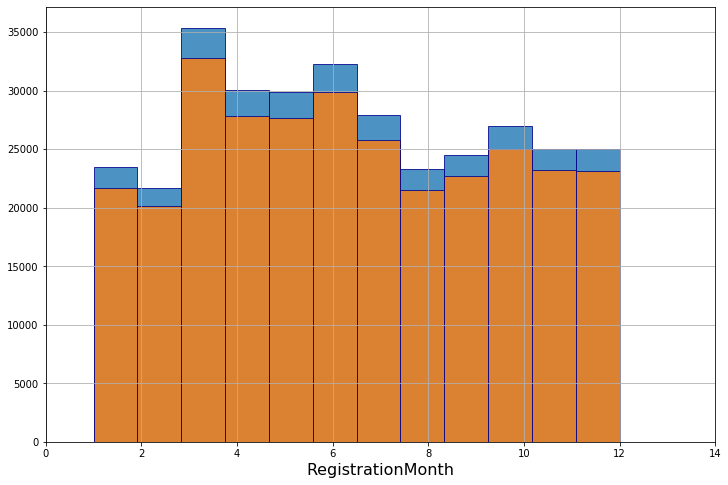

In [78]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
ax.set_xlim([df['RegistrationMonth'].min()-1,df['RegistrationMonth'].max()+2])
ax.grid(b=True, which = 'major' )
plt.hist(df['RegistrationMonth'], alpha=0.8, bins = 12, edgecolor = 'darkblue')
plt.hist(df_old['RegistrationMonth'], alpha=0.8, bins = 12, edgecolor = 'darkblue')
plt.xlabel('RegistrationMonth', fontsize = 16)
plt.show()

In [79]:
df.isnull().sum()

DateCrawled             0
Price                   0
VehicleType          1410
RegistrationYear        0
Gearbox              1423
Power                1323
Model                3280
Kilometer               0
RegistrationMonth    3764
FuelType             1192
Brand                   0
NotRepaired             6
DateCreated             0
NumberOfPictures        0
PostalCode              0
LastSeen                0
dtype: int64

Мы значительно сократили количество пропусков в столбцах. Посмотрим, сколько всего строк сократится, если мы удалим все оставшиеся пропущенные значения. 

In [80]:
nulls = len(df[(df['VehicleType'].isnull() == True)
   |(df['Gearbox'].isnull() == True)
   |(df['Power'].isnull() == True)
   |(df['Model'].isnull() == True)
   |(df['RegistrationMonth'].isnull() == True)
   |(df['FuelType'].isnull() == True)
   |(df['NotRepaired'].isnull() == True)])
nulls

6865

Мы потеряем всего 6865 строк, что более чем приемлемо.

In [82]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322550 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   DateCrawled        322550 non-null  object 
 1   Price              322550 non-null  int64  
 2   VehicleType        322550 non-null  object 
 3   RegistrationYear   322550 non-null  int64  
 4   Gearbox            322550 non-null  object 
 5   Power              322550 non-null  float64
 6   Model              322550 non-null  object 
 7   Kilometer          322550 non-null  int64  
 8   RegistrationMonth  322550 non-null  float64
 9   FuelType           322550 non-null  object 
 10  Brand              322550 non-null  object 
 11  NotRepaired        322550 non-null  object 
 12  DateCreated        322550 non-null  object 
 13  NumberOfPictures   322550 non-null  int64  
 14  PostalCode         322550 non-null  int64  
 15  LastSeen           322550 non-null  object 
dtypes:

## Дубликаты

In [83]:
df[df.duplicated() == True]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193.0,clk,20000,7.0,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
194008,2016-04-04 22:50:44,13000,sedan,2008,manual,143.0,a4,125000,9.0,gasoline,audi,no,2016-04-04 00:00:00,0,65428,2016-04-05 12:30:14
231258,2016-03-28 00:56:10,1000,small,2002,manual,83.0,other,150000,1.0,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218.0,clk,125000,6.0,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131.0,passat,150000,7.0,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


In [84]:
df = df.drop_duplicates().reset_index(drop = True)


## Типы данных

In [86]:
df[df['NotRepaired']=='yes'].count()

DateCrawled          29796
Price                29796
VehicleType          29796
RegistrationYear     29796
Gearbox              29796
Power                29796
Model                29796
Kilometer            29796
RegistrationMonth    29796
FuelType             29796
Brand                29796
NotRepaired          29796
DateCreated          29796
NumberOfPictures     29796
PostalCode           29796
LastSeen             29796
dtype: int64

In [88]:
df.loc[df['NotRepaired']=='yes','NotRepaired'] = 1
df.loc[df['NotRepaired']=='no', 'NotRepaired'] = 0
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,sedan,1993,manual,101.0,golf,150000,12.0,petrol,volkswagen,0,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190.0,a5,125000,5.0,gasoline,audi,1,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163.0,grand,125000,8.0,gasoline,jeep,0,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75.0,golf,150000,6.0,petrol,volkswagen,0,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69.0,fabia,90000,7.0,gasoline,skoda,0,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [89]:
df['NotRepaired'] = df['NotRepaired'].astype('bool')
df['NotRepaired'].sum()

29796

In [90]:
columns_names = ['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'GearboxIsAuto',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen']

In [92]:
df.columns = columns_names
df.loc[df['GearboxIsAuto']=='auto','GearboxIsAuto'] = 1
df.loc[df['GearboxIsAuto']=='manual', 'GearboxIsAuto'] = 0
df['GearboxIsAuto'] = df['GearboxIsAuto'].astype('bool')
df.head()

D:\Tools\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,DateCrawled,Price,VehicleType,RegistrationYear,GearboxIsAuto,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,sedan,1993,False,101.0,golf,150000,12.0,petrol,volkswagen,False,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,False,190.0,a5,125000,5.0,gasoline,audi,True,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,True,163.0,grand,125000,8.0,gasoline,jeep,False,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,False,75.0,golf,150000,6.0,petrol,volkswagen,False,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,False,69.0,fabia,90000,7.0,gasoline,skoda,False,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [89]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'],format='%Y-%m-%dT%H:%M:%S')
df['DateCreated']= pd.to_datetime(df['DateCreated'],format='%Y-%m-%dT%H:%M:%S')
df['LastSeen'] = pd.to_datetime(df['LastSeen'], format='%Y-%m-%dT%H:%M:%S')                                   
df.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,GearboxIsAuto,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,sedan,1993,False,101.0,golf,150000,12.0,petrol,volkswagen,False,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,False,190.0,a5,125000,5.0,gasoline,audi,True,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,True,163.0,grand,125000,8.0,gasoline,jeep,False,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,False,75.0,golf,150000,6.0,petrol,volkswagen,False,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,False,69.0,fabia,90000,7.0,gasoline,skoda,False,2016-03-31,0,60437,2016-04-06 10:17:21


In [90]:
df['RegistrationMonth'] = df['RegistrationMonth'].astype('int')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,GearboxIsAuto,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,sedan,1993,False,101.0,golf,150000,12,petrol,volkswagen,False,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,False,190.0,a5,125000,5,gasoline,audi,True,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,True,163.0,grand,125000,8,gasoline,jeep,False,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,False,75.0,golf,150000,6,petrol,volkswagen,False,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,False,69.0,fabia,90000,7,gasoline,skoda,False,2016-03-31,0,60437,2016-04-06 10:17:21


## Удаление лишних признаков

Прежде, чем приступать к обучению моделей, необходимо исключить из выборок признаки, не влияющие на цену автомобиля, а так же столбец NumberOfPictures, потому что все значения в нем одинаковые.

In [91]:
df_full = copy.deepcopy(df)

In [92]:
df = df.drop(['DateCrawled','DateCreated','NumberOfPictures','PostalCode','LastSeen'], axis = 1)

## Кодирование категориальных признаков

Для того, чтобы сравнить модели градиентного бустинга с моделью случайного леса, необходимо произвести подбор гиперпараметров для случайного леса, а для этого надо закодировать категориальные признаки в данных. 

In [93]:
categorial_features = ['VehicleType', 'Model', 'RegistrationMonth',
                       'FuelType', 'Brand']

In [94]:
df[categorial_features]

,VehicleType,Model,RegistrationMonth,FuelType,Brand
0,sedan,golf,12,petrol,volkswagen
1,coupe,a5,5,gasoline,audi
2,suv,grand,8,gasoline,jeep
3,small,golf,6,petrol,volkswagen
4,small,fabia,7,gasoline,skoda
...,...,...,...,...,...
322540,sedan,leon,5,petrol,seat
322541,bus,zafira,3,petrol,opel
322542,convertible,fortwo,3,petrol,smart
322543,bus,transporter,3,gasoline,volkswagen


In [95]:
ordin = OrdinalEncoder()

ordin.fit(df[categorial_features])
df_ordin = pd.DataFrame(data = ordin.transform(df[categorial_features]), columns = df[categorial_features].columns)
df_ordin.head()

,VehicleType,Model,RegistrationMonth,FuelType,Brand
0,4.0,116.0,11.0,6.0,37.0
1,2.0,30.0,4.0,2.0,1.0
2,6.0,117.0,7.0,2.0,14.0
3,5.0,116.0,5.0,6.0,37.0
4,5.0,101.0,6.0,2.0,31.0
...,...,...,...,...,...
322540,4.0,140.0,4.0,6.0,30.0
322541,0.0,249.0,2.0,6.0,24.0
322542,1.0,106.0,2.0,6.0,32.0
322543,0.0,224.0,2.0,2.0,37.0


In [96]:
df_ordin['Price'] = df['Price']
df_ordin['RegistrationYear'] = df['RegistrationYear']
df_ordin['GearboxIsAuto'] = df['GearboxIsAuto']
df_ordin['Power'] = df['Power']
df_ordin['Kilometer'] = df['Kilometer']
df_ordin['NotRepaired'] = df['NotRepaired']
df_ordin.head()

,VehicleType,Model,RegistrationMonth,FuelType,Brand,Price,RegistrationYear,GearboxIsAuto,Power,Kilometer,NotRepaired
0,4.0,116.0,11.0,6.0,37.0,480,1993,False,101.0,150000,False
1,2.0,30.0,4.0,2.0,1.0,18300,2011,False,190.0,125000,True
2,6.0,117.0,7.0,2.0,14.0,9800,2004,True,163.0,125000,False
3,5.0,116.0,5.0,6.0,37.0,1500,2001,False,75.0,150000,False
4,5.0,101.0,6.0,2.0,31.0,3600,2008,False,69.0,90000,False
...,...,...,...,...,...,...,...,...,...,...,...
322540,4.0,140.0,4.0,6.0,30.0,3200,2004,False,225.0,150000,True
322541,0.0,249.0,2.0,6.0,24.0,1150,2000,False,125.0,150000,False
322542,1.0,106.0,2.0,6.0,32.0,1199,2000,True,101.0,125000,False
322543,0.0,224.0,2.0,2.0,37.0,9200,1996,False,102.0,150000,False


# 2. Обучение моделей

### CatBoostRegressor

Разобьем не кодированные данные на выборки и подберем гиперпараметры, при которых CatBoostRegressor продемонстрирует наименьший показатель RMSE.

In [97]:
features_trainvalid, features_test, target_trainvalid, target_test = train_test_split(
    df.drop('Price', axis=1), df.Price, test_size=0.25, random_state=state)

In [98]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_trainvalid, target_trainvalid, test_size=0.25, random_state=state)

Составим список категориальных признаков, чтобы передать его алгоритму. Добавим туда и RegistrationMonth: несмотря на то, что мы не стали заменять тип данных в этом столбце или переименовывать числовые обозначения месяцев ради удобства, по сути значения этого признака - категории, и будет неправильно, если алгоритм считает их и будет оперировать ими, как количественными данными. 

In [99]:
categorial_features = ['VehicleType', 'Model', 'RegistrationMonth',
                       'FuelType', 'Brand']

Напишем функцию, перебирающую по несколько вариантов гиперпараметров, выберем их сочетание, дающее модель с лучшим rmse на валидационной выборке. 

In [100]:
%%time
def CatBoost_search(features_train, target_train, features_valid, target_valid):
    learning_rate_col = []
    depth_col = []
    l2_leaf_reg_col = []
    iterations_col = []
    rmse_col = []
    for depth in [12, 16]:
        for l2_leaf_reg in [2,5]:
            for learn_rate in [0.1,0.5]:
                for iterations in [80]:
                    catboost_model = CatBoostRegressor(loss_function = 'RMSE',
                                                       iterations = iterations,
                                                       depth = depth,
                                                       l2_leaf_reg = l2_leaf_reg,
                                                       learning_rate = learn_rate,
                                                       random_state = state, 
                                                       verbose = False)
                    catboost_model.fit(features_train, 
                                       target_train, 
                                       cat_features=categorial_features, 
                                       verbose=False)
                    catboost_predicted_valid = catboost_model.predict(features_valid)
                    rmse_score = mean_squared_error(target_valid, catboost_predicted_valid) ** 0.5
                    depth_col.append(depth)
                    l2_leaf_reg_col.append(l2_leaf_reg)
                    learning_rate_col.append(learn_rate)
                    iterations_col.append(iterations)
                    rmse_col.append(rmse_score)
    catboost_hyperparameters_dict = {'depth': depth_col, 
                                     'l2_leaf_reg': l2_leaf_reg_col, 
                                     'learning_rate': learning_rate_col, 
                                     'iterations': iterations_col, 
                                     'rmse_score': rmse_col}
    catboost_hyperparameters = pd.DataFrame(data = catboost_hyperparameters_dict)
    return catboost_hyperparameters

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


In [101]:
%%time
CatBoost_results = CatBoost_search(features_train, target_train, features_valid, target_valid)

CPU times: user 13min 35s, sys: 1min 57s, total: 15min 33s
Wall time: 16min 2s


In [102]:
CatBoost_results = CatBoost_results.sort_values(by = 'rmse_score')

In [103]:
CatBoost_results

,depth,l2_leaf_reg,learning_rate,iterations,rmse_score
3,12,5,0.5,80,1611.067360
7,16,5,0.5,80,1614.442645
1,12,2,0.5,80,1621.089826
5,16,2,0.5,80,1624.712925
4,16,2,0.1,80,1626.608866
6,16,5,0.1,80,1633.167082
0,12,2,0.1,80,1661.497804
2,12,5,0.1,80,1671.326940


In [104]:
CatBoost_best_hyper = CatBoost_results.head(1)
CatBoost_best_hyper

,depth,l2_leaf_reg,learning_rate,iterations,rmse_score
3,12,5,0.5,80,1611.06736


Перебор гиперпараметров занял достаточно большое время (притом, что их было немного), но результат получен. Сохраним значения гиперпараметров для проверки на тестовой выборке.

In [105]:
CatBoost_best_depth = int(CatBoost_best_hyper['depth'])
CatBoost_best_l2_leaf_reg = int(CatBoost_best_hyper['l2_leaf_reg'])
CatBoost_best_learning_rate = float(CatBoost_best_hyper['learning_rate'])
CatBoost_best_iterations = int(CatBoost_best_hyper['iterations'])

### LGBMRegressor

В LGBMRegressor можно передать категориальные данные, но мы посмотрим, как он работает с кодированными данными. 

In [97]:
ordin_features_trainvalid, ordin_features_test, ordin_target_trainvalid, ordin_target_test = train_test_split(
    df_ordin.drop('Price', axis=1), df_ordin.Price, test_size=0.25, random_state=state)

In [98]:
ordin_features_train, ordin_features_valid, ordin_target_train, ordin_target_valid = train_test_split(
    ordin_features_trainvalid, ordin_target_trainvalid, test_size=0.25, random_state=state)

In [99]:
test_LGBM = LGBMRegressor(objective="regression", eval_metric='rmse',
                                                       iterations = 80,
                                                       max_depth = 15,
                                                       reg_lambda = 2,
                                                       learning_rate = 0.1,
                                                       random_state = state)

In [100]:
test_LGBM.fit(ordin_features_train, ordin_target_train, verbose=0, feature_name = list(ordin_features_train.columns), categorical_feature = categorial_features)


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Model', 'RegistrationMonth', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              eval_metric='rmse', importance_type='split', iterations=80,
              learning_rate=0.1, max_depth=15, min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_leaves=31, objective='regression',
              random_state=1234, reg_alpha=0.0, reg_lambda=2, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [101]:
%%time
def LGBM_search(features_train, target_train, features_valid, target_valid):
    learning_rate_col = []
    max_depth_col = []
    reg_lambda_col = []
    iterations_col = []
    rmse_col = []
    for depth in [12, 18]:
        for reg_lambda in [2,5]:
            for learn_rate in [0.1,0.5]:
                for iterations in [80]:
                    LGBM_model = LGBMRegressor(objective="regression", eval_metric='rmse',
                                                       iterations = iterations,
                                                       max_depth = depth,
                                                       reg_lambda = reg_lambda,
                                                       learning_rate = learn_rate,
                                                       random_state = state)
                    LGBM_model.fit(features_train,
                                   target_train,
                                   verbose=0,feature_name = list(features_train.columns), categorical_feature = categorial_features)
                    LGBM_predicted_valid = LGBM_model.predict(features_valid)
                    rmse_score = mean_squared_error(target_valid, LGBM_predicted_valid) ** 0.5
                    max_depth_col.append(depth)
                    reg_lambda_col.append(reg_lambda)
                    learning_rate_col.append(learn_rate)
                    iterations_col.append(iterations)
                    rmse_col.append(rmse_score)
    LGBM_hyperparameters_dict = {'max_depth': max_depth_col, 
                                     'reg_lambda': reg_lambda_col, 
                                     'learning_rate': learning_rate_col, 
                                     'iterations': iterations_col, 
                                     'rmse_score': rmse_col}
    LGBM_hyperparameters = pd.DataFrame(data = LGBM_hyperparameters_dict)
    return LGBM_hyperparameters

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10.3 µs


In [102]:
%%time
LGBM_results = LGBM_search(ordin_features_train, ordin_target_train, ordin_features_valid, ordin_target_valid)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Model', 'RegistrationMonth', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Model', 'RegistrationMonth', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Model', 'RegistrationMonth', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.

CPU times: user 1min 3s, sys: 472 ms, total: 1min 4s
Wall time: 1min 5s


In [103]:
LGBM_results = LGBM_results.sort_values(by = 'rmse_score')
LGBM_best_hyper = LGBM_results.head(1)
LGBM_best_hyper

,max_depth,reg_lambda,learning_rate,iterations,rmse_score
3,12,5,0.5,80,1627.763898


Перебор примерно тех же гиперпараметров занял куда меньшее время, а rmse на валидационной выборке гораздо меньше, чем продемонстрировал CatBoostRegressor. Сохраним значения гиперпараметров для проверки на тестовой выборке.

In [104]:
LGBM_best_depth = int(LGBM_best_hyper['max_depth'])
LGBM_best_reg_lambda = int(LGBM_best_hyper['reg_lambda'])
LGBM_best_learning_rate = float(LGBM_best_hyper['learning_rate'])
LGBM_best_iterations = int(LGBM_best_hyper['iterations'])

### RandomForestRegressor

Сравним алгоритмы градиентного бустинга со старым добрым случайным лесом. Он не принимает категориалные признаки вообще, поэтому использование кодированных данных необходимо.

In [105]:
%%time
def forest_search(features_train, target_train, features_valid, target_valid):
    forest_depth_col = []
    forest_min_leaf_col = []
    forest_min_split_col = []
    forest_estim_col = []
    forest_score_col = []
    for depth in [12,18]:
        for n_estim in [80]:
            for min_leaf in range (5,12,3):
                for min_split in range (4,12,4):
                    forest_model = RandomForestRegressor(n_estimators = n_estim, 
                                                   max_depth = depth, 
                                                   min_samples_split = min_split, 
                                                   min_samples_leaf = min_leaf, 
                                                   random_state = state)
                    forest_model.fit(features_train, target_train)
                    forest_predicted_valid = forest_model.predict(features_valid)
                    rmse_score = mean_squared_error(target_valid, forest_predicted_valid) ** 0.5
                    forest_depth_col.append(depth)
                    forest_min_leaf_col.append(min_leaf)
                    forest_min_split_col.append(min_split)
                    forest_estim_col.append(n_estim)
                    forest_score_col.append(rmse_score)
    forest_hyperparameters_dict = {'max_depth': forest_depth_col, 'min_samples_split': forest_min_split_col, 'min_samples_leaf': forest_min_leaf_col, 'n_estimators': forest_estim_col, 'rmse_score': forest_score_col}
    forest_hyperparameters = pd.DataFrame(data = forest_hyperparameters_dict)
    return forest_hyperparameters


CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.11 µs


In [106]:
%%time
forest_results = forest_search(ordin_features_train, ordin_target_train, ordin_features_valid, ordin_target_valid)

CPU times: user 7min 7s, sys: 1.21 s, total: 7min 9s
Wall time: 7min 10s


In [107]:
forest_results = forest_results.sort_values(by = 'rmse_score')
forest_best_hyper = forest_results.head(1)
forest_best_hyper

,max_depth,min_samples_split,min_samples_leaf,n_estimators,rmse_score
6,18,4,5,80,1635.353914


In [108]:
forest_results

,max_depth,min_samples_split,min_samples_leaf,n_estimators,rmse_score
6,18,4,5,80,1635.353914
7,18,8,5,80,1635.353914
8,18,4,8,80,1659.582299
9,18,8,8,80,1659.582299
10,18,4,11,80,1683.669144
11,18,8,11,80,1683.669144
0,12,4,5,80,1766.760370
1,12,8,5,80,1766.760370
2,12,4,8,80,1773.438844
3,12,8,8,80,1773.438844


Перебор параметров занял какое-то время, хотя и меньшее, чем у CatBoost, но rmse на валидационной выборке получился даже ниже, чем у LGBMRegressor.  

In [109]:
forest_best_depth = int(forest_best_hyper['max_depth'])
forest_best_min_samples_split = int(forest_best_hyper['min_samples_split'])
forest_best_min_samples_leaf = int(forest_best_hyper['min_samples_leaf'])
forest_best_n_estimators = int(forest_best_hyper['n_estimators'])

# 3. Анализ моделей

Сопоставим получившиеся модели по показателям, волнующим заказчика: точности предсказания, скорости предсказания, времени обучения модели.  
Для большей точности обучим модели каждого алгоритма с лучшими обнаруженными гиперпараметрами на объединенных обучащих и валидационных выборках.

In [119]:
%%time
CatBoost_best_model = CatBoostRegressor(loss_function = 'RMSE',
                                        iterations = CatBoost_best_iterations,
                                        depth = CatBoost_best_depth,
                                        l2_leaf_reg = CatBoost_best_l2_leaf_reg,
                                        learning_rate = CatBoost_best_learning_rate,
                                        random_state = state)
CatBoost_best_model.fit(features_trainvalid, target_trainvalid, cat_features=categorial_features, verbose=5)

0:	learn: 3022.3984495	total: 697ms	remaining: 55s
5:	learn: 1799.2654171	total: 3.91s	remaining: 48.2s
10:	learn: 1703.2992121	total: 7.12s	remaining: 44.6s
15:	learn: 1647.4672573	total: 10.4s	remaining: 41.6s
20:	learn: 1611.8477701	total: 13.6s	remaining: 38.2s
25:	learn: 1583.3210133	total: 17.1s	remaining: 35.5s
30:	learn: 1563.0914388	total: 20.3s	remaining: 32.1s
35:	learn: 1542.1453854	total: 23.5s	remaining: 28.7s
40:	learn: 1521.5321823	total: 26.7s	remaining: 25.4s
45:	learn: 1497.0634862	total: 29.9s	remaining: 22.1s
50:	learn: 1479.4293595	total: 33.1s	remaining: 18.8s
55:	learn: 1466.8015999	total: 36.2s	remaining: 15.5s
60:	learn: 1458.6635774	total: 39.3s	remaining: 12.2s
65:	learn: 1443.8882110	total: 42.6s	remaining: 9.03s
70:	learn: 1425.6279318	total: 45.8s	remaining: 5.8s
75:	learn: 1417.3002131	total: 49.1s	remaining: 2.58s
79:	learn: 1412.1371758	total: 51.6s	remaining: 0us
CPU times: user 49 s, sys: 3.34 s, total: 52.3 s
Wall time: 56 s


In [120]:
%%time
CatBoost_predicted_test = CatBoost_best_model.predict(features_test)                    

CPU times: user 301 ms, sys: 12.3 ms, total: 313 ms
Wall time: 295 ms


In [121]:
CatBoost_rmse_test = mean_squared_error(target_test, CatBoost_predicted_test) ** 0.5
CatBoost_rmse_test

1607.9025757123661

Обучение модели CatBoost составило 49секунд - 1 минуту.  
Скорость предсказания модели CatBoost составила 295-369 миллисекунд.  
RMSE модели CatBoost: 1607.9025757123661.

In [110]:
%%time
LGBM_best_model = LGBMRegressor(objective="regression", eval_metric='rmse',
                                iterations = LGBM_best_iterations,
                                max_depth = LGBM_best_depth,
                                reg_lambda = LGBM_best_reg_lambda,
                                learning_rate = LGBM_best_learning_rate,
                                random_state = state)
LGBM_best_model.fit(ordin_features_trainvalid, ordin_target_trainvalid)

CPU times: user 7.27 s, sys: 66.8 ms, total: 7.34 s
Wall time: 7.36 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              eval_metric='rmse', importance_type='split', iterations=80,
              learning_rate=0.5, max_depth=12, min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_leaves=31, objective='regression',
              random_state=1234, reg_alpha=0.0, reg_lambda=5, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [111]:
%%time
LGBM_predicted_test = LGBM_best_model.predict(ordin_features_test)    

CPU times: user 618 ms, sys: 0 ns, total: 618 ms
Wall time: 607 ms


In [112]:
LGBM_rmse_test = mean_squared_error(ordin_target_test, LGBM_predicted_test) ** 0.5
LGBM_rmse_test

1640.7738523561534

Обучение модели LGBM составило 6.97-7.88 секунд.  
Скорость предсказания модели LGBM составила 541-595 миллисекунд.  
RMSE модели LGBM 1640.7738523561534.

In [113]:
%%time
forest_best_model = RandomForestRegressor(n_estimators = forest_best_n_estimators,
                                          max_depth = forest_best_depth,
                                          min_samples_split = forest_best_min_samples_split, 
                                          min_samples_leaf = forest_best_min_samples_leaf, 
                                          random_state = state)
forest_best_model.fit(ordin_features_trainvalid, ordin_target_trainvalid)

CPU times: user 1min 1s, sys: 182 ms, total: 1min 2s
Wall time: 1min 2s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=18,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=80,
                      n_jobs=None, oob_score=False, random_state=1234,
                      verbose=0, warm_start=False)

In [114]:
%%time
forest_predicted_test = forest_best_model.predict(ordin_features_test)   

CPU times: user 2.16 s, sys: 12 ms, total: 2.18 s
Wall time: 2.21 s


In [115]:
forest_rmse_test = mean_squared_error(ordin_target_test, forest_predicted_test) ** 0.5
forest_rmse_test

1615.3689542747138

Обучение модели RandomForestRegressor составило 49.3-54.6 секунд.  
Скорость предсказания модели RandomForestRegressor составила 1.61 - 1.78 секунды.  
Показатель RMSE модели RandomForestRegressor равен 1615.3689542747138.

# Вывод

Самую высокую точность показал CatBoostRegressor, случайный лес, несильно отставая, показал второй результат, и LGBMRegressor - третий (тоже, впрочем, уступающий несильно).

Скорость предсказания в целом выше у CatBoostRegressor, LGBM медленнее, хотя обе модели давали предсказание быстрее секунды. Случайному лесу потребовалось на это около полутора секунд. В показаниях существует определенный разброс, поскольку результаты получались немного другими за два подхода.

Скорость обучения выше всего у LGBMRegressor, у него обучение занимает несколько секунд, у CatBooster и случайного леса на обучение уходит около минуты. 

Поскольку для модели, которая должна рекомендовать клиенту анкету из уже имеющегося пула анкет, скорость обучения, которое можно производить периодически, в любое время и независимо от запроса клиентта, не так важна, как скорость предсказания - то есть скорость ответа клиенту на запрос - и точность предсказания, лидер в которых однозначно опрделен, выбрана модель на основе CatBoostRegressor.  